# Are vars mixed up time intervals? Lets sort it out!

Lately, I was gazing at the beatiful graphs created by Chris Deotte here:
https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899/notebook

..and noticed that they look like mixed up cartoon frames. They have similar pattern, proportions, but they are just mixed up, on different scale and sometimes flipped. So I have cleaned it up; here is the result. 

# The list of columns that have to be reversed
If you take a look at the orginal graphs by Chris Deotte, notice how similar the probability graphs are. But some are directed to the right, while others are directed to the left. We will flip the graphs with the higest probabilty on the right. And we'll bring everything to one scale to make similarities more pronounced.

In [1]:
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]

# Load data

In [2]:
import numpy as np, pandas as pd
train_file = '../input/train.csv'
test_file = '../input/test.csv'

train = pd.read_csv(train_file, index_col='ID_code')
X_test = pd.read_csv(test_file, index_col='ID_code')

In [3]:
y_train = train.iloc[:,0]
X_train = train.iloc[:,1:]

In [4]:
X_all = pd.concat([X_test, X_train])

# Scale and flip
I doubt that standard scaler is the correct way to restore the original scale for the frames. But alternatives looked even worse.

In [5]:
from sklearn.preprocessing import StandardScaler

x = X_all.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
X_all = pd.DataFrame(x_scaled).set_index(X_all.index)

In [6]:
X_all.loc[:,reverse_list] = X_all.loc[:,reverse_list]*-1

In [7]:
X_all.columns = X_train.columns

In [8]:
test = X_all.loc[X_test.index,:].reset_index(drop=True)
train = X_all.loc[X_train.index,:].reset_index(drop=True)

In [9]:
train0 = train[y_train.values==0].copy()
train1 = train[y_train.values==1].copy()

# Statistical Functions
Below are functions to calcuate various statistical things.

In [10]:
# CALCULATE MEANS AND STANDARD DEVIATIONS
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(train['var_'+str(i)])
    m[i] = np.mean(train['var_'+str(i)])
    
# CALCULATE PROB(TARGET=1 | X)
def getp(i,x):
    c = 3 #smoothing factor
    a = len( train1[ (train1['var_'+str(i)]>x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)]>x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    if a+b<500: return 0.1 #smoothing factor
    # RETURN PROBABILITY
    return a / (a+b)
    # ALTERNATIVELY RETURN ODDS
    # return a / b
    
# SMOOTH A DISCRETE FUNCTION
def smooth(x,st=1):
    for j in range(st):
        x2 = np.ones(len(x)) * 0.1
        for i in range(len(x)-2):
            x2[i+1] = 0.25*x[i]+0.5*x[i+1]+0.25*x[i+2]
        x = x2.copy()
    return x

# The frames: Display Target Density and Target Probability
As described by Chris: "Below are two plots for each of the 200 variables. The first is the density of `target=1` versus `target=0`. The second gives the probability that `target=1` given different values for `var_k`." 

Note how the shape and the range of graphs are consistnent. All we need to do is to sort them in the right order. Does not it remind you of the last Santander? I am pretty sure the correct order can be restored.

Showing vars 0 to 7 ...


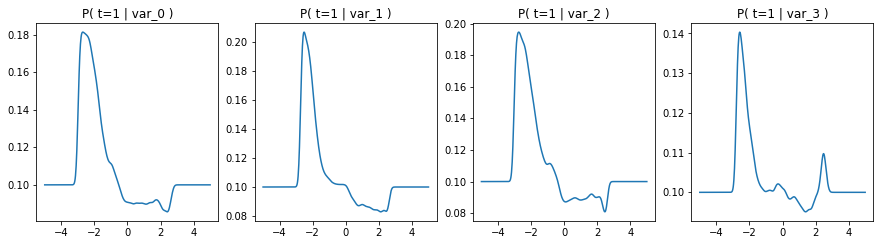

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# DRAW PLOTS, YES OR NO
Picture = True
# DATA HAS Z-SCORE RANGE OF -4.5 TO 4.5
rmin=-5; rmax=5; 
# CALCULATE PROBABILITIES FOR 501 BINS
res=501
# STORE PROBABILITIES IN PR
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in range(50):
    if Picture: plt.figure(figsize=(15,8))
    for v in range(4):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):
            pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
            xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
            xr2[v+4*j,ct] = i
            ct += 1
            pr2[v+4*j,:] = smooth(pr[v+4*j,:],res//10)
        if Picture:
            # SMOOTH FUNCTION FOR PRETTIER DISPLAY
            # BUT USE UNSMOOTHED FUNCTION FOR PREDICTION

            # DISPLAY PROBABILITY FUNCTION
            plt.subplot(2, 4, ct2%4+5)
            plt.plot(xr[v+4*j,:],pr2[v+4*j,:],'-')
            plt.title('P( t=1 | var_'+str(v+4*j)+' )')
            xx = plt.xlim()
            # DISPLAY TARGET DENSITIES
           
        if (ct2%8==0): print('Showing vars',ct2,'to',ct2+7,'...')
        ct2 += 1
    
    if Picture: plt.show()
    if(j==0):
        break

# Afterthoughts
These does not look random. I have not tried to go beyond this, Yet, if it works, don't forget to say thanks to Chris Deotte.

In [12]:
pr2[0]

array([0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1    

In [13]:
new_df = pd.DataFrame()
for i in range(0,200):
    new_df['var_pb_'+str(i)] = pr2[i]

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Columns: 200 entries, var_pb_0 to var_pb_199
dtypes: float64(200)
memory usage: 782.9 KB


In [15]:
corr_mat = new_df.corr(method='pearson')
corr_mat

,var_pb_0,var_pb_1,var_pb_2,var_pb_3,var_pb_4,var_pb_5,var_pb_6,var_pb_7,var_pb_8,var_pb_9,var_pb_10,var_pb_11,var_pb_12,var_pb_13,var_pb_14,var_pb_15,var_pb_16,var_pb_17,var_pb_18,var_pb_19,var_pb_20,var_pb_21,var_pb_22,var_pb_23,var_pb_24,var_pb_25,var_pb_26,var_pb_27,var_pb_28,var_pb_29,var_pb_30,var_pb_31,var_pb_32,var_pb_33,var_pb_34,var_pb_35,var_pb_36,var_pb_37,var_pb_38,var_pb_39,...,var_pb_160,var_pb_161,var_pb_162,var_pb_163,var_pb_164,var_pb_165,var_pb_166,var_pb_167,var_pb_168,var_pb_169,var_pb_170,var_pb_171,var_pb_172,var_pb_173,var_pb_174,var_pb_175,var_pb_176,var_pb_177,var_pb_178,var_pb_179,var_pb_180,var_pb_181,var_pb_182,var_pb_183,var_pb_184,var_pb_185,var_pb_186,var_pb_187,var_pb_188,var_pb_189,var_pb_190,var_pb_191,var_pb_192,var_pb_193,var_pb_194,var_pb_195,var_pb_196,var_pb_197,var_pb_198,var_pb_199
var_pb_0,1.000000e+00,9.190397e-01,9.912534e-01,8.757716e-01,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,...,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15,9.584758e-15
var_pb_1,9.190397e-01,1.000000e+00,8.856767e-01,9.261662e-01,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,...,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15,5.064065e-15
var_pb_2,9.912534e-01,8.856767e-01,1.000000e+00,8.596011e-01,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,...,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15,8.878553e-15
var_pb

In [16]:
corr_mat.to_csv('prob_based_cormat.csv',index=True, float_format='%.6f')
new_df.to_csv('prob_by_var.csv', index=False, float_format='%.6f')